# Example 2

Conducting site reponse analyses on multiple sites concurrently is slightly cumbersome with pyStrata.  
  
  To this end, I have developed a few functions that allow one to quickly compute transfer functions and resposne spectra for large groups of sites and motions.

In [1]:
from datools import site_response_small

### Step 0: Construct Site Profiles

The profile object in pyStrata describes the various Layer objects that constitute, well, a soil strata.
  
  There are several different soil models included in pystrata describing the nonlinear strain compatable properties (e.g., Darendeli (2001), Menq (2004), Kishida (2012)). For this demonstration however, I will be showing how to construct a generic soil profile (used subsequently for a Linear Elastic Site Response Analysis).  
    
    
  You either manually construct a profile for a site:


In [2]:
import pystrata
profile = pystrata.site.Profile([
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 1.0, 110.0),
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 34.0, 250.0),
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 55.0, 1200.0),
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 52.0, 490.0),
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 62.0, 700.0),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 20.0, None, 0.01), 0.0, 700.0)
    ])
print(profile)

Or generate several profiles at once using the included DAtools functions.  
  
  First, you can download the profile information from Kik-Net ([here](https://www.kyoshin.bosai.go.jp/kyoshin/db/index_en.html?all)), and construct a .txt file with all of the relevant soil property information for as many sites as needed:

```text
FKSH11
vs = [110.00,250.00,1200.00,490.00,700.00] #m/s
OCR = [1.00,1.00,1.00,1.00,1.00]
PI = [10.00,10.00,10.00,10.00,10.00]
uw = 20.00  #kN/m^3
thick = [1.00,33.00,22.00,30.00,32.00]  #m
mean_stress = [6.67, 125.42, 312.24, 488.87, 699.46] #kN/m^2
gwl = 1   #ground water level (m)

KMMH14
(con.)
```

Then, you can automatically construct both dataframes and pyStrata Profiles.

In [3]:
site_data = site_response_small.parse_site_data('data/Example_2/site_data.txt')
# Print head for each site's data frame
for site in ['FKSH11', 'KMMH14']:
    print(f"Data for {site}:")
    print(site_data[site].head())
    print()

Data for FKSH11:
   Layer      Vs  Mean_Stress  OCR    PI  Unit_Weight  Thickness
0      1   110.0         6.67  1.0  10.0         20.0        1.0
1      2   250.0       125.42  1.0  10.0         20.0       33.0
2      3  1200.0       312.24  1.0  10.0         20.0       22.0
3      4   490.0       488.87  1.0  10.0         20.0       30.0
4      5   700.0       699.46  1.0  10.0         20.0       32.0

Data for KMMH14:
   Layer     Vs  Mean_Stress  OCR    PI  Unit_Weight  Thickness
0      1  110.0        26.67  1.0  10.0         20.0        4.0
1      2  180.0        93.33  1.0  10.0         20.0        6.0
2      3  330.0       167.30  1.0  10.0         20.0       10.0
3      4  480.0       330.34  1.0  10.0         20.0       38.0
4      5  480.0       561.31  1.0  10.0         20.0       30.0



In [4]:
profiles = {}
for site, df in site_data.items():
    uw = df['Unit_Weight'].iloc[0] 
    PI = df['PI'].tolist()
    OCR = df['OCR'].tolist()
    mean_stress = df['Mean_Stress'].tolist()
    thick = df['Thickness'].tolist()
    vs = df['Vs'].tolist()
    sf = 1.0  # Dmin Scale Factor
    
    profile = site_response_small.create_soil_profile(
        uw=uw,
        PI=PI,
        OCR=OCR,
        mean_stress=mean_stress,
        thick=thick,
        vs=vs,
        sf=sf
    )
    profiles[site] = profile

profiles

{'FKSH11': <pystrata.site.Profile at 0x1293bf730>,
 'KMMH14': <pystrata.site.Profile at 0x1293be3e0>}

### Step 1: Bring in the Processed Ground Motion Data

The next step is to bring in the ground motion data that needs to be analyzed in the site resposne analysis. First, I am going to bring the data in as an Obspy Stream object (see Example 1 for more information on Obspy).

Total EW1 traces for FKSH11 combined: 2
Total EW2 traces for FKSH11 combined: 2
Total NS1 traces for FKSH11 combined: 3
Total NS2 traces for FKSH11 combined: 3
Total large surface traces combined for FKSH11: 5
Total large base traces combined for FKSH11: 5
Total EW1 traces for FKSH11 combined: 10
Total EW2 traces for FKSH11 combined: 10
Total NS1 traces for FKSH11 combined: 10
Total NS2 traces for FKSH11 combined: 10
Total small surface traces combined for FKSH11: 20
Total small base traces combined for FKSH11: 20


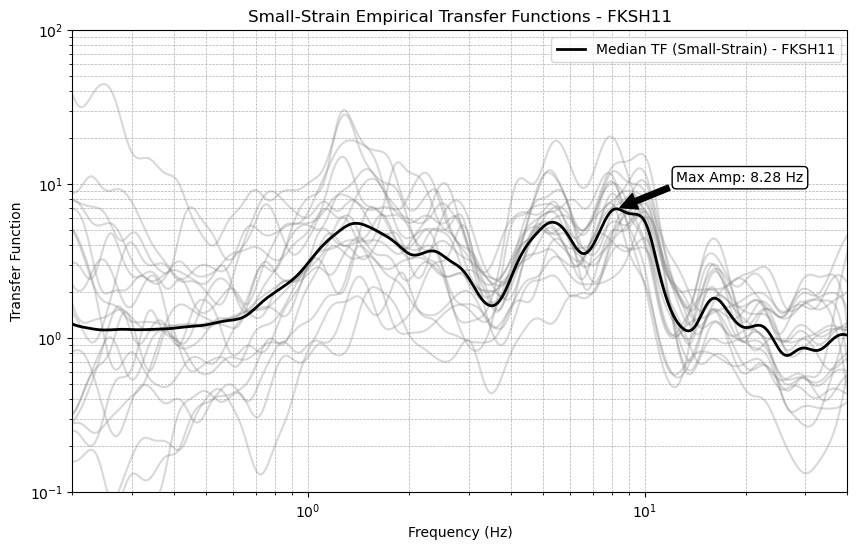

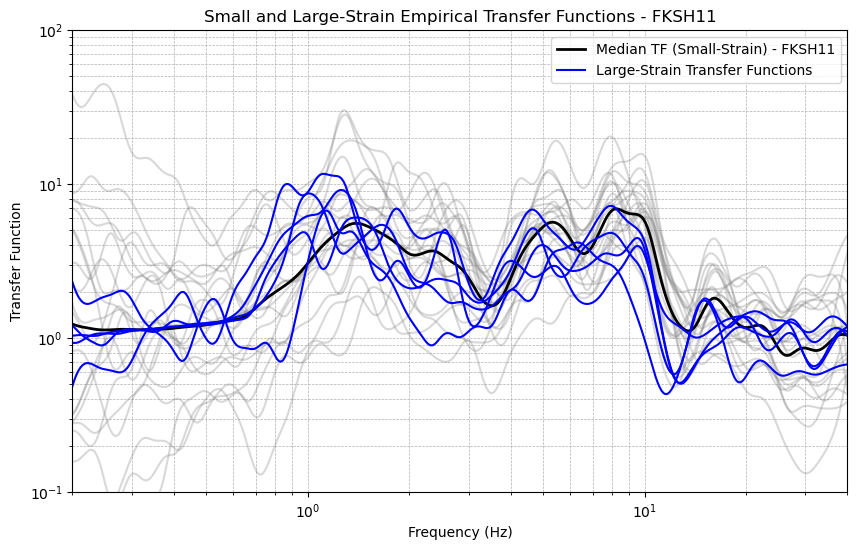

Total EW1 traces for KMMH14 combined: 3
Total EW2 traces for KMMH14 combined: 3
Total NS1 traces for KMMH14 combined: 3
Total NS2 traces for KMMH14 combined: 3
Total large surface traces combined for KMMH14: 6
Total large base traces combined for KMMH14: 6
Total EW1 traces for KMMH14 combined: 9
Total EW2 traces for KMMH14 combined: 9
Total NS1 traces for KMMH14 combined: 10
Total NS2 traces for KMMH14 combined: 10
Total small surface traces combined for KMMH14: 19
Total small base traces combined for KMMH14: 19


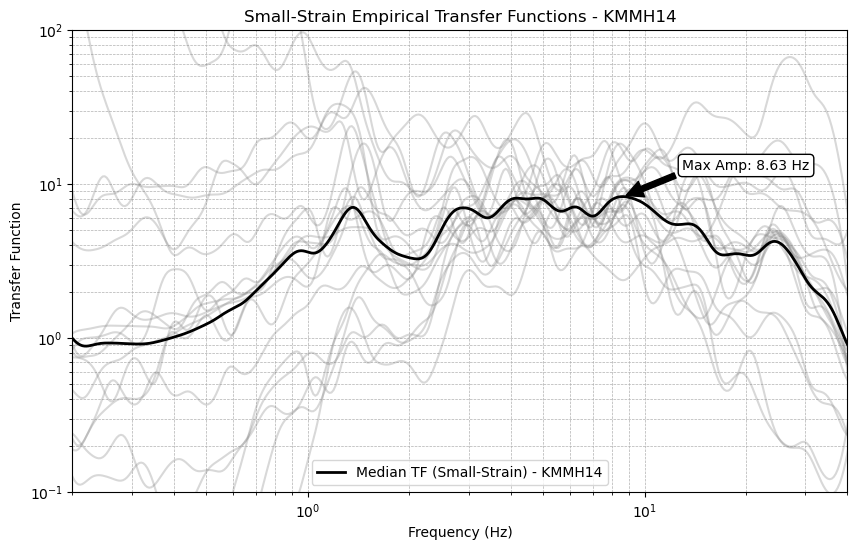

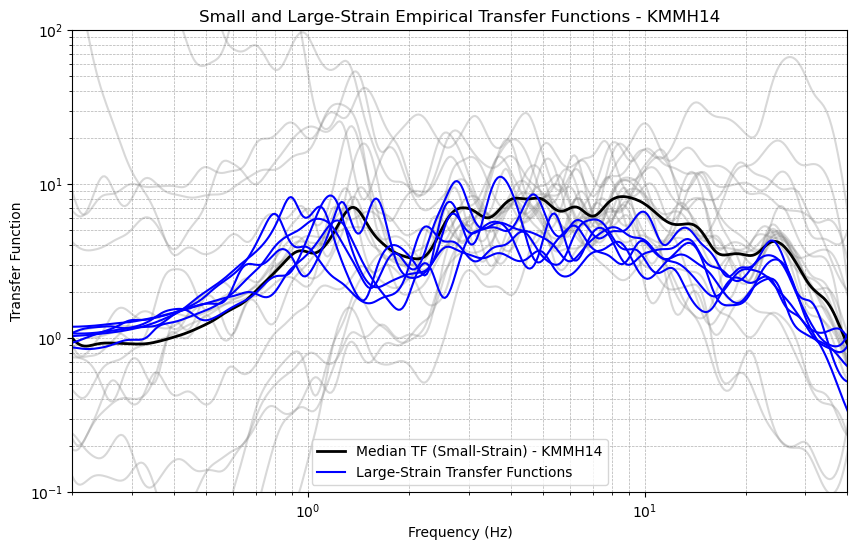

In [5]:
import numpy as np
mp='data/Example_2'
for profile_name, profile in profiles.items():
    base_small_df, surface_small_df, base_large_df, surface_large_df = site_response_small.process_profile(profile_name, profile, mp)
    site_response_small.plot_transfer_functions(base_small_df, surface_small_df, base_large_df, surface_large_df, profile_name)

Total EW1 traces for KMMH14 combined: 3
Total EW2 traces for KMMH14 combined: 3
Total NS1 traces for KMMH14 combined: 3
Total NS2 traces for KMMH14 combined: 3
Total large surface traces combined for KMMH14: 6
Total large base traces combined for KMMH14: 6
Total EW1 traces for KMMH14 combined: 9
Total EW2 traces for KMMH14 combined: 9
Total NS1 traces for KMMH14 combined: 10
Total NS2 traces for KMMH14 combined: 10
Total small surface traces combined for KMMH14: 19
Total small base traces combined for KMMH14: 19


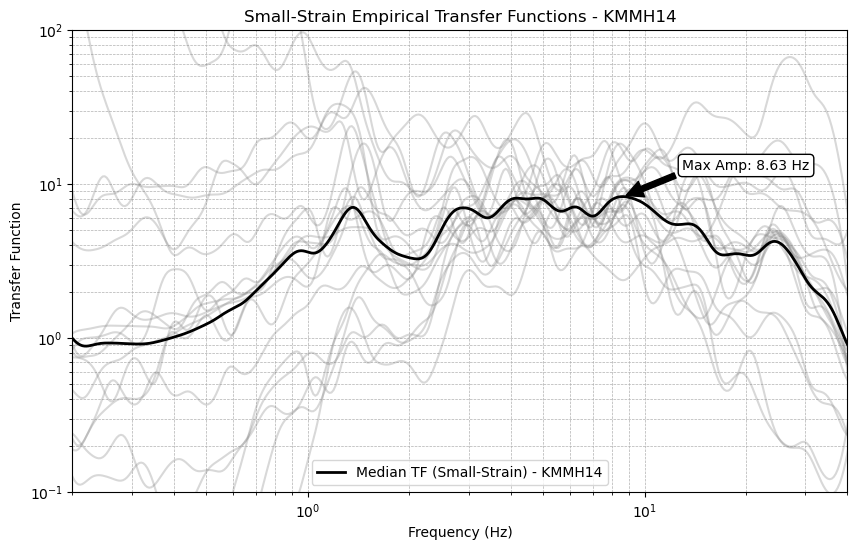

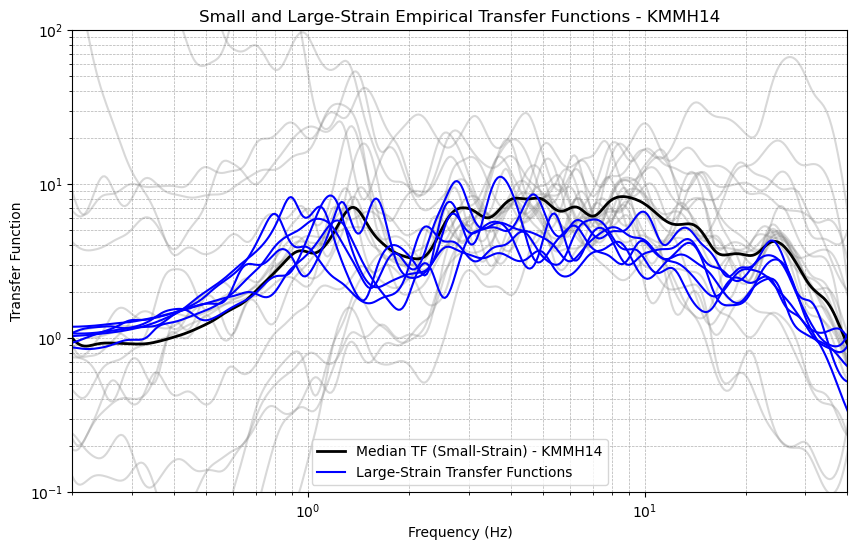

In [8]:
base_small_df, surface_small_df, base_large_df, surface_large_df = site_response_small.process_profile(profile_name, profile, mp)
site_response_small.plot_transfer_functions(base_small_df, surface_small_df, base_large_df, surface_large_df, profile_name)